In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split

from tensorflow.keras import datasets, layers, models
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

In [ ]:
def crop_brain_contour(image, plot=False):
    
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


Mounted at /content/gdrive


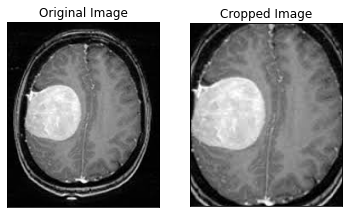

In [ ]:
ex_img = cv2.imread('/content/gdrive/MyDrive/yes/Y1.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

In [ ]:
def load_data(dir_list, image_size):
    

    X = []
    y = []
    image_width, image_height = image_size
    c=0;
    for directory in dir_list:
        c=c+1
        for filename in listdir(directory):
            c=c+1
            print(c)
            image = cv2.imread(directory + '/' + filename)
            image = crop_brain_contour(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            image = image / 255.
            X.append(image)
            
            if directory[-3:] == 'YES':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [ ]:
augmented_path = '/content/gdrive/MyDrive/augumented/'

augmented_YES = '/content/gdrive/MyDrive/augumented/YES' 
augmented_no = '/content/gdrive/MyDrive/augumented/no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_YES, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
def plot_sample_images(X, y, n=50):
    
    
    for label in [0,1]:
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1      
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

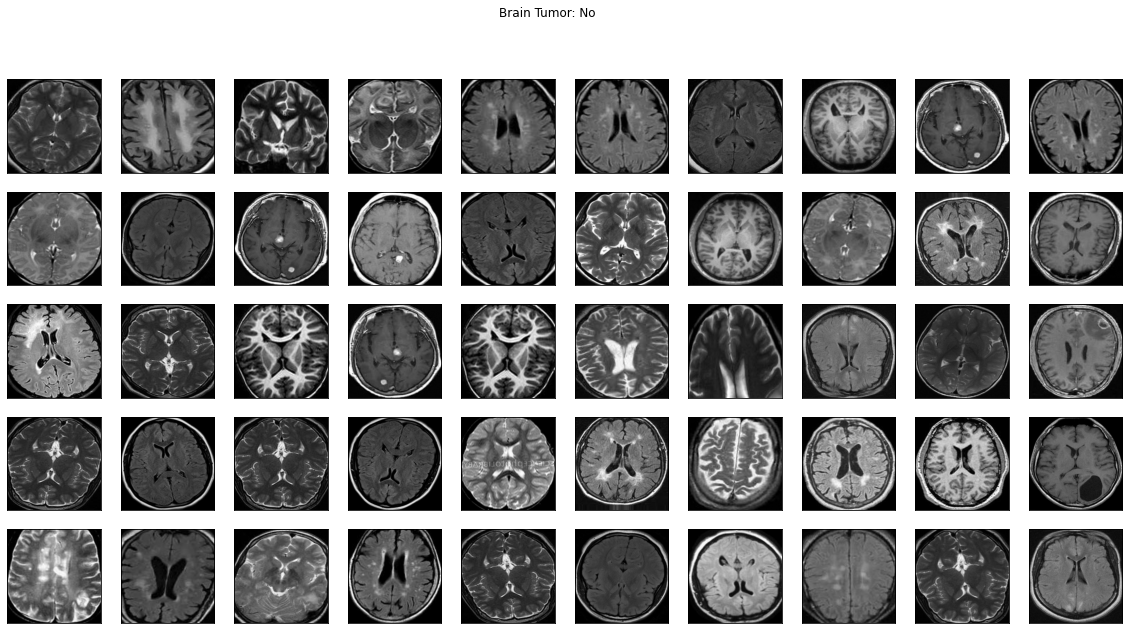

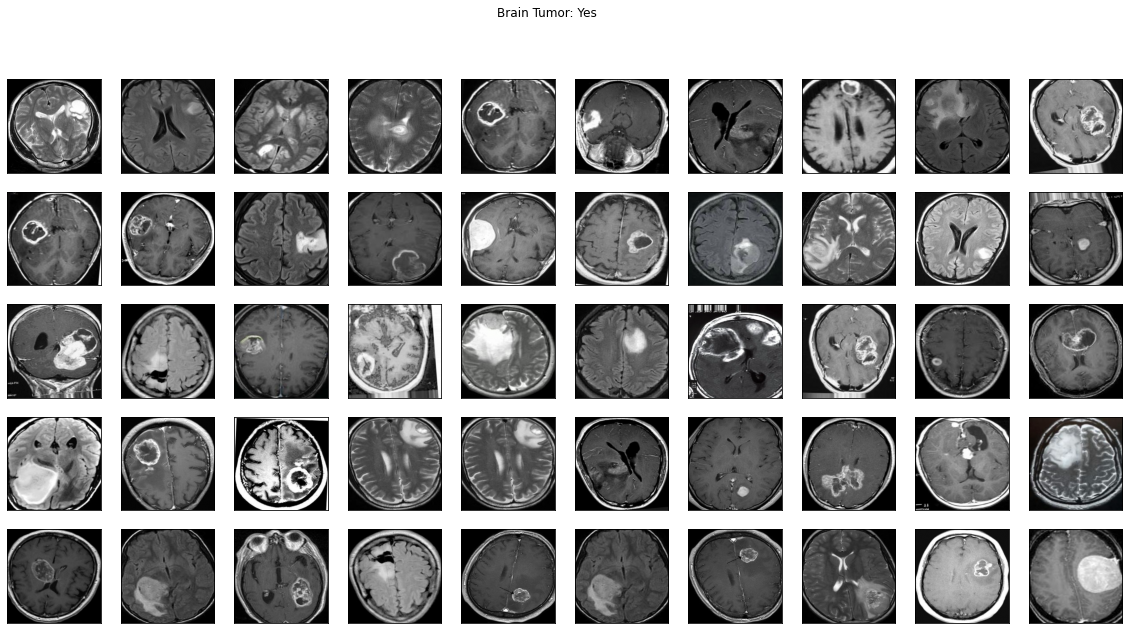

In [ ]:
plot_sample_images(X, y)

In [ ]:
def split_data(X, y, test_size=0.2):
       
   
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [ ]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1435
number of development examples = 308
number of test examples = 307
X_train shape: (1435, 240, 240, 3)
Y_train shape: (1435, 1)
X_val (dev) shape: (308, 240, 240, 3)
Y_val (dev) shape: (308, 1)
X_test shape: (307, 240, 240, 3)
Y_test shape: (307, 1)


In [ ]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [ ]:
def compute_f1_score(y_true, prob):
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

In [ ]:
input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)
X_input = Input(input_shape) 
X = ZeroPadding2D((2, 2))(X_input) 
X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
X = Activation('relu')(X) 
    
X = MaxPooling2D((4, 4), name='max_pool0')(X) 
    
X = MaxPooling2D((4, 4), name='max_pool1')(X) 
    
X = Flatten()(X) 
X = Dense(1, activation='sigmoid', name='fc')(X) 
    
model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    


In [ ]:
model.summary()

Model: "BrainDetectionModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
zero_padding2d_5 (ZeroPaddin (None, 244, 244, 3)       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 238, 238, 32)      4736      
_________________________________________________________________
activation_5 (Activation)    (None, 238, 238, 32)      0         
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 59, 59, 32)        0         
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 6272)      

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [ ]:

filepath="cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}"
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'))

In [ ]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=36, validation_split=0.1, epochs=14, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/14
36/36 [==============================] - 34s 86ms/step - loss: 0.6744 - accuracy: 0.6096 - val_loss: 0.6180 - val_accuracy: 0.7083
INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-01-0.71.model/assets
Epoch 2/14
36/36 [==============================] - 2s 48ms/step - loss: 0.5744 - accuracy: 0.7196 - val_loss: 0.4646 - val_accuracy: 0.8264
INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-02-0.83.model/assets
Epoch 3/14
36/36 [==============================] - 2s 48ms/step - loss: 0.4718 - accuracy: 0.8017 - val_loss: 0.4155 - val_accuracy: 0.8333
INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-03-0.83.model/assets
Epoch 4/14
36/36 [==============================] - 2s 49ms/step - loss: 0.4223 - accuracy: 0.8110 - val_loss: 0.3736 - val_accuracy: 0.8333
INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-04-0.83.model/assets
Epoch 5/14
36/36 [==============================] - 2s 49ms/step - loss: 0.

In [ ]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

In [ ]:
history = model.history.history


In [ ]:
for key in history.keys():
    print(key)

loss
accuracy
val_loss
val_accuracy


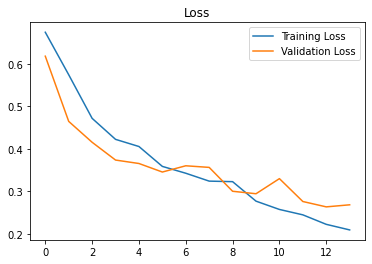

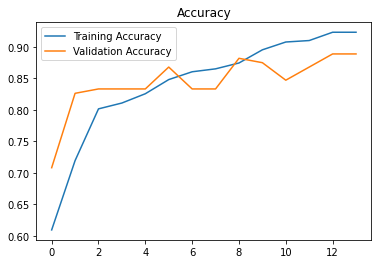

In [ ]:
plot_metrics(history)

In [ ]:
best_model = load_model(filepath='models/cnn-parameters-improvement-14-0.89.model')

In [ ]:
best_model.metrics_names

['loss', 'accuracy']

In [ ]:
loss, acc = best_model.evaluate(x=X_test, y=y_test)

10/10 [==============================] - 1s 38ms/step - loss: 0.3138 - accuracy: 0.8795


In [ ]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.31381163001060486
Test Accuracy = 0.8794788122177124


In [ ]:
y_test_prob = best_model.predict(X_test)

In [ ]:
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

F1 score: 0.877887788778878


In [ ]:
y_val_prob = best_model.predict(X_val)

In [ ]:
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.8745980707395498


In [ ]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}")

In [ ]:
data_percentage(y)

Number of examples: 2050
Percentage of positive examples: 52.19512195121951%, number of pos examples: 1070
Percentage of negative examples: 47.80487804878049%, number of neg examples: 980


In [ ]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 1435
Percentage of positive examples: 52.75261324041812%, number of pos examples: 757
Percentage of negative examples: 47.24738675958188%, number of neg examples: 678
Validation Data:
Number of examples: 308
Percentage of positive examples: 51.298701298701296%, number of pos examples: 158
Percentage of negative examples: 48.701298701298704%, number of neg examples: 150
Testing Data:
Number of examples: 307
Percentage of positive examples: 50.4885993485342%, number of pos examples: 155
Percentage of negative examples: 49.5114006514658%, number of neg examples: 152


In [ ]:
tf.keras.models.save_model(
    model,
    filepath,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)
filepath = 'saved_model'
save_model(model, filepath, save_format='h5')

INFO:tensorflow:Assets written to: tmp/model/assets


In [ ]:
from tensorflow.keras.models import Sequential, save_model, load_model
import numpy as np


In [ ]:
loaded_model = load_model(
    filepath,
    custom_objects=None,
    compile=True
)

In [ ]:
sample_index = 1
sample_input, sample_target = X_train[sample_index], y_train[sample_index]
sample_input_array = np.array([sample_input])
predictions = loaded_model.predict(sample_input_array)
prediction = np.argmax(predictions[0])
print(f'Ground truth: {sample_target} - Prediction: {prediction}')

Ground truth: [1] - Prediction: 0


In [ ]:

r = model.predict(X_train)
print(r)

[[0.6048687 ]
 [0.98136055]
 [0.00129844]
 ...
 [0.7584209 ]
 [0.00247583]
 [0.7949452 ]]


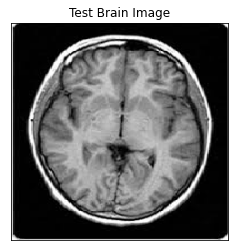

[[[255. 255. 255.]
  [249. 249. 249.]
  [251. 251. 251.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[249. 249. 249.]
  [255. 255. 255.]
  [254. 254. 254.]
  ...
  [255. 255. 255.]
  [250. 250. 250.]
  [254. 254. 254.]]

 [[247. 247. 247.]
  [255. 255. 255.]
  [248. 248. 248.]
  ...
  [243. 243. 243.]
  [243. 243. 243.]
  [252. 252. 252.]]

 ...

 [[253. 253. 253.]
  [253. 253. 253.]
  [242. 242. 242.]
  ...
  [255. 255. 255.]
  [254. 254. 254.]
  [254. 254. 254.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [252. 252. 252.]
  ...
  [253. 253. 253.]
  [254. 254. 254.]
  [254. 254. 254.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [254. 254. 254.]
  [254. 254. 254.]]]
[[[[255. 255. 255.]
   [249. 249. 249.]
   [251. 251. 251.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  [[249. 249. 249.]
   [255. 255. 255.]
   [254. 254. 254.]
   ...
   [255. 255. 255.]
   [250. 250. 250.]
   [254. 254. 254.]]

  [[

In [ ]:
test_image = image.load_img('/content/gdrive/MyDrive/no/20 no.jpg', target_size = (240, 240))
plt.imshow(test_image)
plt.title('Test Brain Image'), plt.xticks([]), plt.yticks([])
plt.show()
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
print(result)
if result[0][0] == 1:
    prediction = 'brain tumor present'
else:
    prediction = 'no brain tumor'
print(prediction)